In [1]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
import pickle
import glob
from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

In [2]:
class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))+c

def Gauss_2d_LC_func_gen(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt_gen(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V


In [4]:
# OCTOBER 21 FLIGHT READ IN

keys1021 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/20211021T*')]
keys1021.sort()

dict1021 = {}
for key in keys1021:
    with open('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
        f.close()
    dict1021[key] = dict_to_class_cut(loaded_dict)
    print(key)


20211021T135147Z
20211021T144917Z
20211021T151703Z
20211021T161512Z
20211021T164751Z
20211021T183443Z
20211021T185818Z
20211021T192225Z
20211021T203219Z
20211021T205711Z
20211021T214040Z
20211021T220657Z


In [5]:
len(keys1021)

12

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


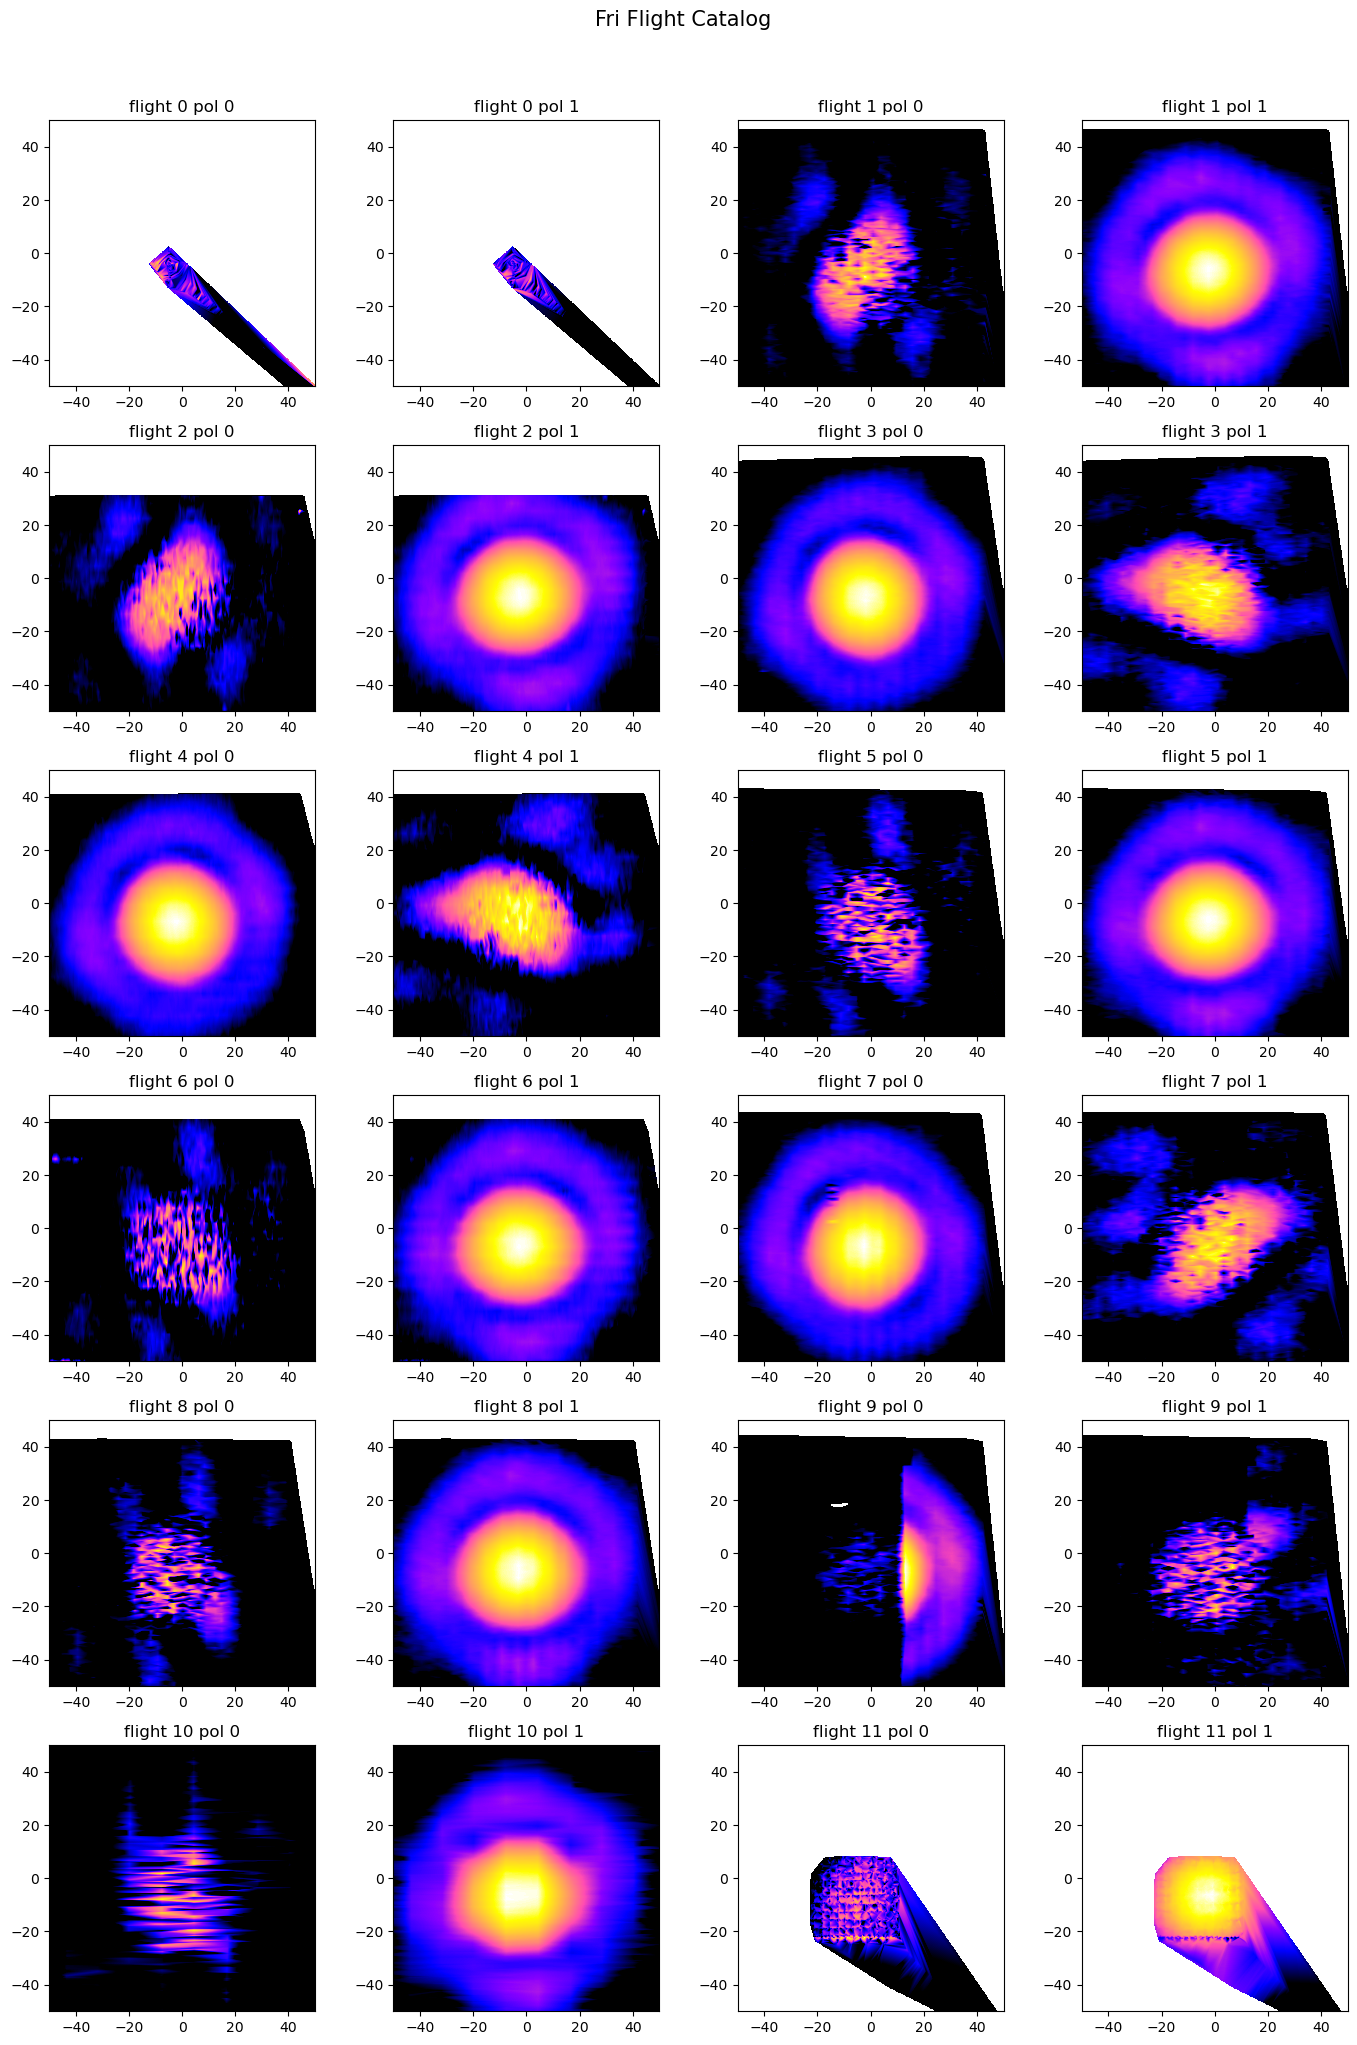

In [6]:
fig=figure(figsize=(14,20))
counter = 1
vmin_ = -105

for k, i in enumerate(keys1021):
    dotsize=2
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
    y = dict1021[i].drone_xyz_LC_interp[indsuse,1]
    X,Y = np.meshgrid(np.linspace(-50,50,1000), np.linspace(-50,50,1000))
    
    ax=fig.add_subplot(6,4,counter)
    z = 10*np.log10(np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,0], axis = 1)))
    Z0 = griddata((x,y), z, (X,Y))
    ax.imshow(Z0, extent=(-50,50,-50,50), cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 0')
   
    counter +=1
    ax=fig.add_subplot(6,4,counter)
    z = 10*np.log10(np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,1], axis = 1)))
    Z0 = griddata((x,y), z, (X,Y))
    ax.imshow(Z0, extent=(-50,50,-50,50), cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 1')
    counter +=1

suptitle('Fri Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


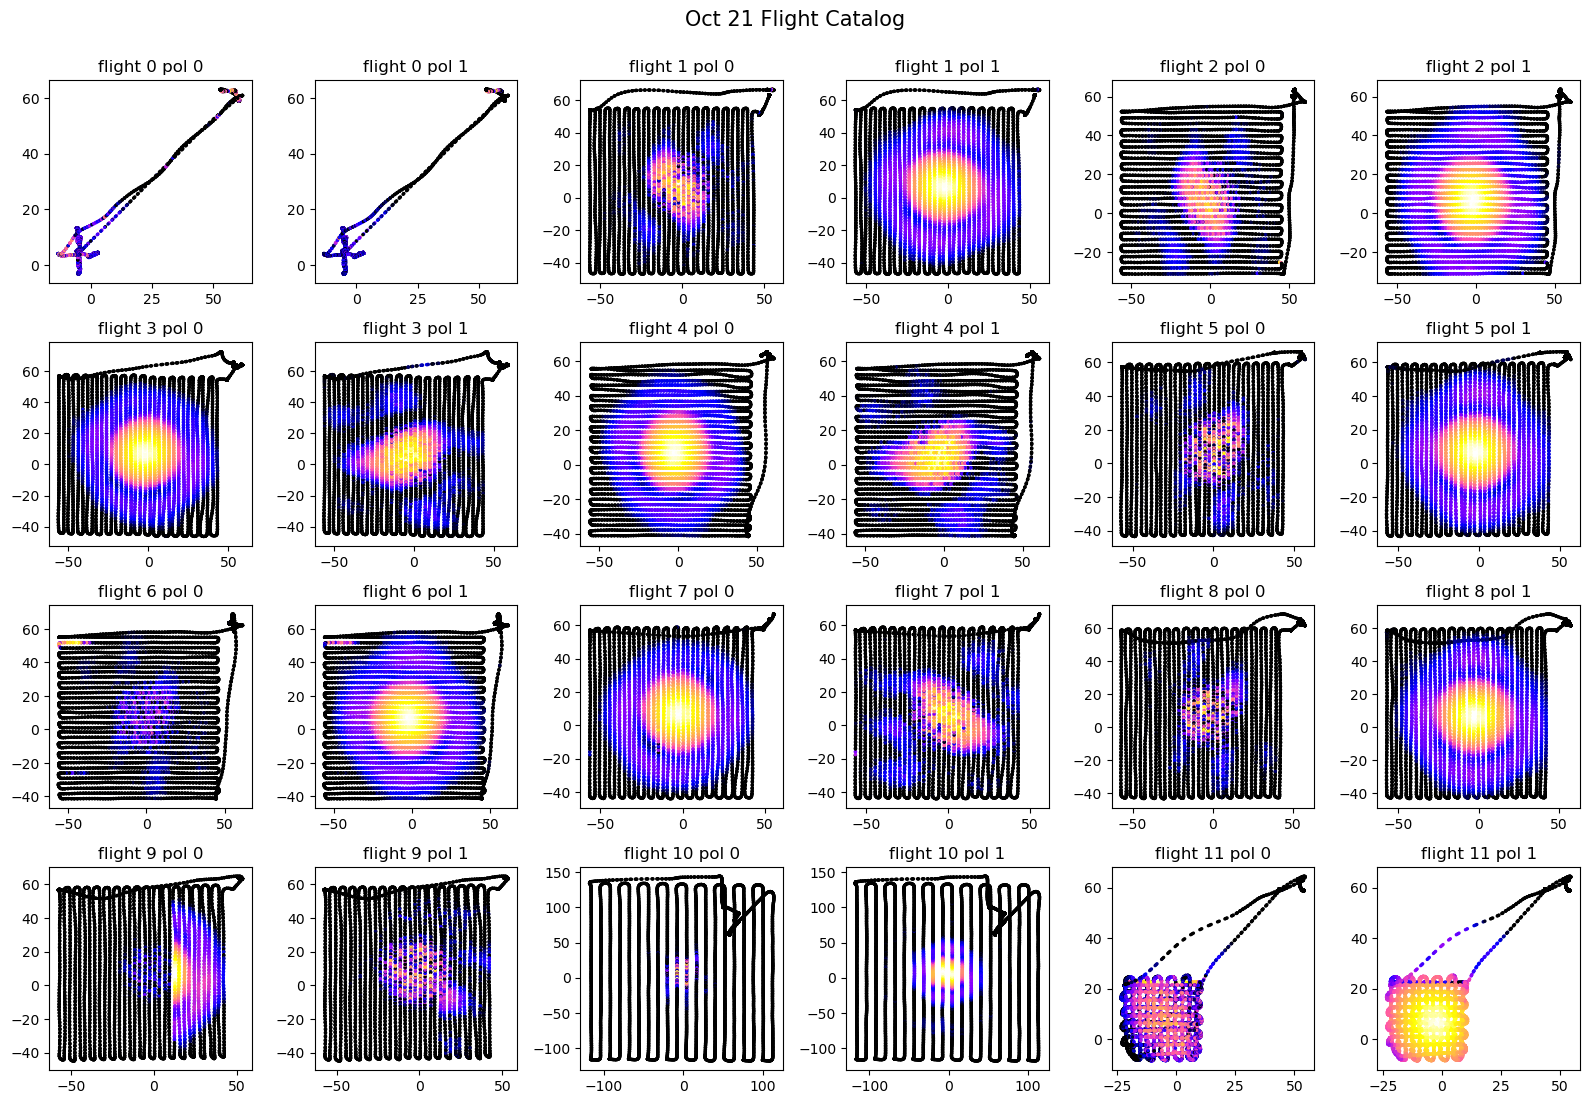

In [13]:
fig=figure(figsize=(16,16))
counter = 1
vmin_ = -105

for k, i in enumerate(keys1021):
    dotsize=2
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
    y = dict1021[i].drone_xyz_LC_interp[indsuse,1]   
    
    ax=fig.add_subplot(6,6,counter)
    z = 10*np.log10(np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,0], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 0')
   
    counter +=1
    ax=fig.add_subplot(6,6,counter)
    z = 10*np.log10(np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,1], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 1')
    counter +=1

suptitle('Oct 21 Flight Catalog', y=1.0, fontsize = 15)
tight_layout()

In [8]:
X,Y = np.meshgrid(np.linspace(-50,50,500), np.linspace(-50,50,500))

i = keys1021[3]
inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
y = dict1021[i].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,0], axis = 1)))
Z3 = griddata((x,y), z, (X,Y))

i = keys1021[4]
inds_on_cut=np.intersect1d(np.arange(len(dict1021[i].t_arr_datetime)),dict1021[i].inds_on).tolist()
indsuse = [j for j in inds_on_cut if str(dict1021[i].drone_xyz_LC_interp[j,0]) != 'nan']
x = dict1021[i].drone_xyz_LC_interp[indsuse,0]
y = dict1021[i].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict1021[i].V_bgsub[indsuse,freq:freq+10,0], axis = 1)))
Z4 = griddata((x,y), z, (X,Y))

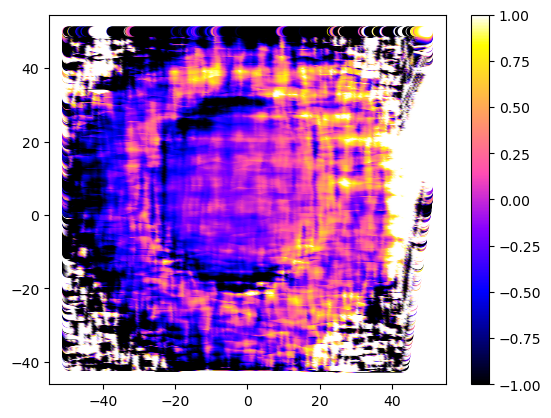

In [9]:
scatter(X,Y,c = 10*np.log10(Z3)-10*np.log10(Z4), vmin = -1, vmax = 1, cmap='gnuplot2')
colorbar()

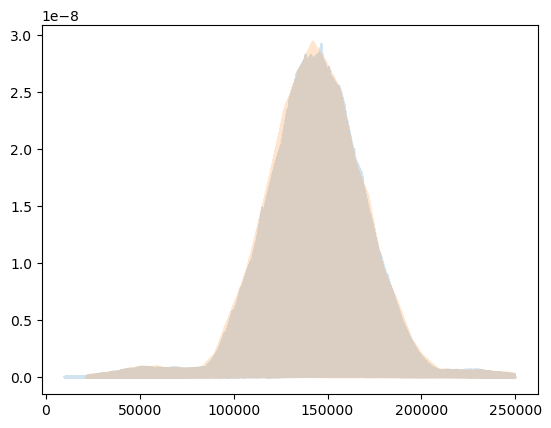

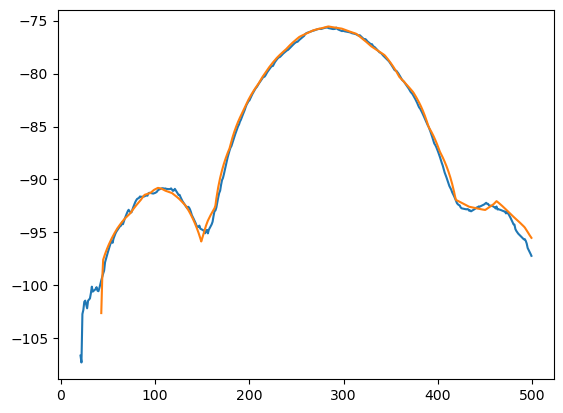

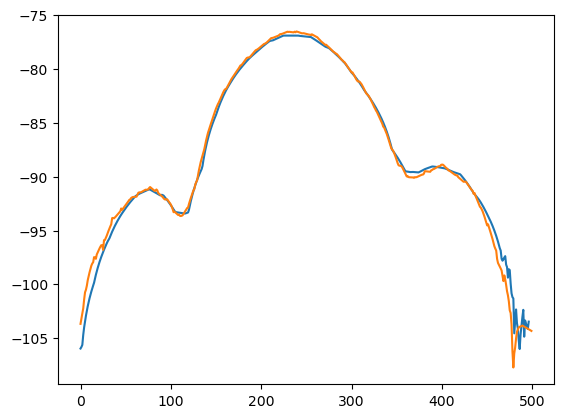

In [10]:
plot(Z3.ravel(), alpha = 0.2)
plot(Z4.ravel(), alpha = 0.2)
show()

plot(10*np.log10(Z3[:,250]))
plot(10*np.log10(Z4[:,250]))

show()

plot(10*np.log10(Z3[250,:]))
plot(10*np.log10(Z4[250,:]))

